# Data Augmentation using Keras Preprocessing Layers.

**Let’s start by importing some basic libraries that we’ll need:**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

**Downloading the dataset**

In [3]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

The flowers dataset has five classes. To view them:

In [4]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


Now, Let’s get an image from the dataset to demonstrate data augmentation.

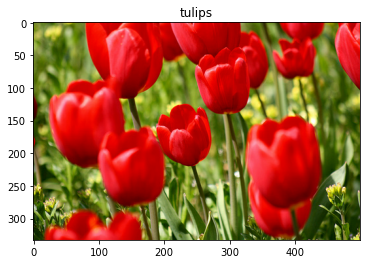

In [5]:
get_label_name = metadata.features['label'].int2str
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

**Resizing and rescaling images.**

You can now use Keras preprocessing layers to resize your images to a consistent shape or to rescale pixel values.

In [6]:
IMG_SIZE = 180
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

Now, to view the resulting image,

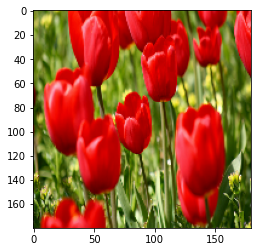

In [7]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

**Data augmentation using preprocessing layers**

You can also use preprocessing layers for data augmentation. Let’s start by creating a few preprocessing layers and applying them to the same image.

In [8]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

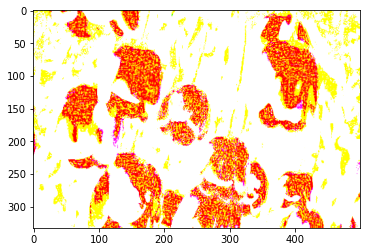

In [9]:
result = data_augmentation(image)
_ = plt.imshow(result)

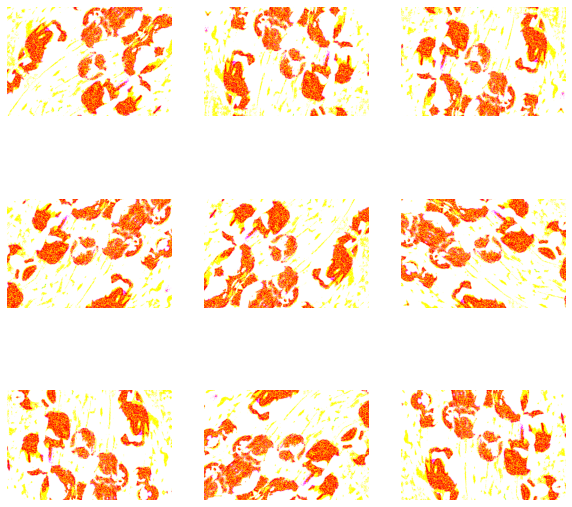

In [10]:
image = tf.expand_dims(image, 0)
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

There are several preprocessing layers you can use for data augmentation. Some examples include layers.RandomContrast, layers.RandomCrop, layers.RandomZoom, and others.

#### **Two options to use the preprocessing layers**

**Option 1: Make the preprocessing layers part of your model** 

In [11]:
model = tf.keras.Sequential([
resize_and_rescale,
data_augmentation,
layers.Conv2D(16, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
# Rest of your model
])

**Option 2: Apply the preprocessing layers to your dataset**

In [12]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

In [13]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)
  
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

**Train a model**

In [ ]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)


Epoch 1/5
92/92 [==============================] - 31s 312ms/step - loss: 1.5954 - accuracy: 0.2708 - val_loss: 1.5886 - val_accuracy: 0.3161
Epoch 2/5
92/92 [==============================] - 28s 299ms/step - loss: 1.5687 - accuracy: 0.2885 - val_loss: 1.5920 - val_accuracy: 0.2534
Epoch 3/5
92/92 [==============================] - 29s 308ms/step - loss: 1.5641 - accuracy: 0.2916 - val_loss: 1.5993 - val_accuracy: 0.1744
Epoch 4/5
92/92 [==============================] - 29s 311ms/step - loss: 1.5523 - accuracy: 0.3082 - val_loss: 1.6339 - val_accuracy: 0.1689
Epoch 5/5
13/92 [===>..........................] - ETA: 24s - loss: 1.5371 - accuracy: 0.3486

**Custom data augmentation**

You can also create custom data augmentation layers.

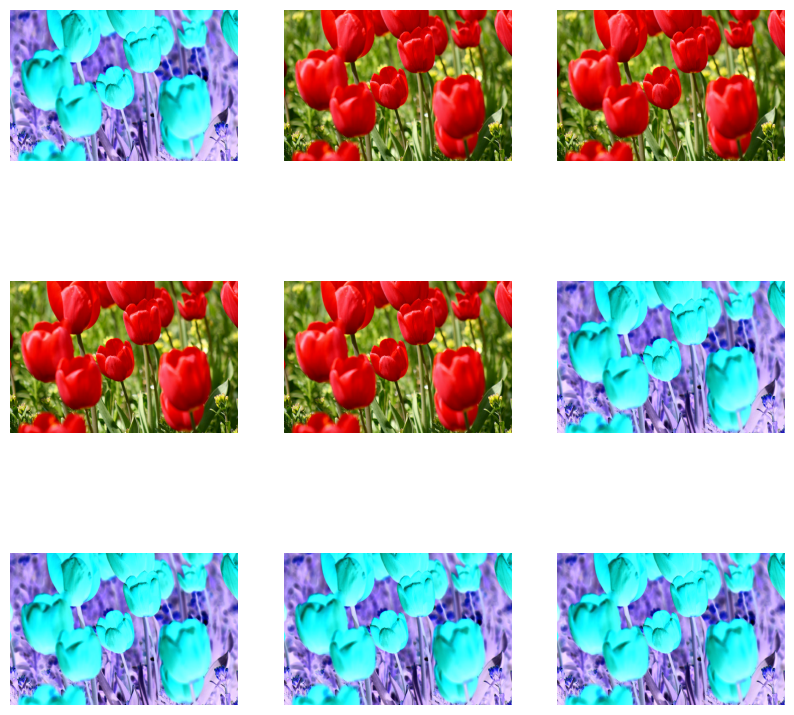

In [ ]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p: x = (255-x)
  else: x
  return x
  
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

Next, implement a custom layer by subclassing.

In [ ]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)